In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.io import imread

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

### Dataset
The dataset is CMU face images from UCI Machine Learning Repository, the data is downloaded in to the folder named 'faces'.The dataset consists of 640 black-white face images of people taken with varying pose (straight, left, right, up), expression (neutral, happy, sad, angry), eyes (wearing sunglasses or not), and size(na,2,4). In the folder, photos of each person is saved in one folder with his/her name, each folder contains .pgm files, which is named in the format of name_pose_expression_eyes_size.pgm.

Source: Mitchell,Tom. (1999). CMU Face Images. UCI Machine Learning Repository. https://doi.org/10.24432/C5JC79.

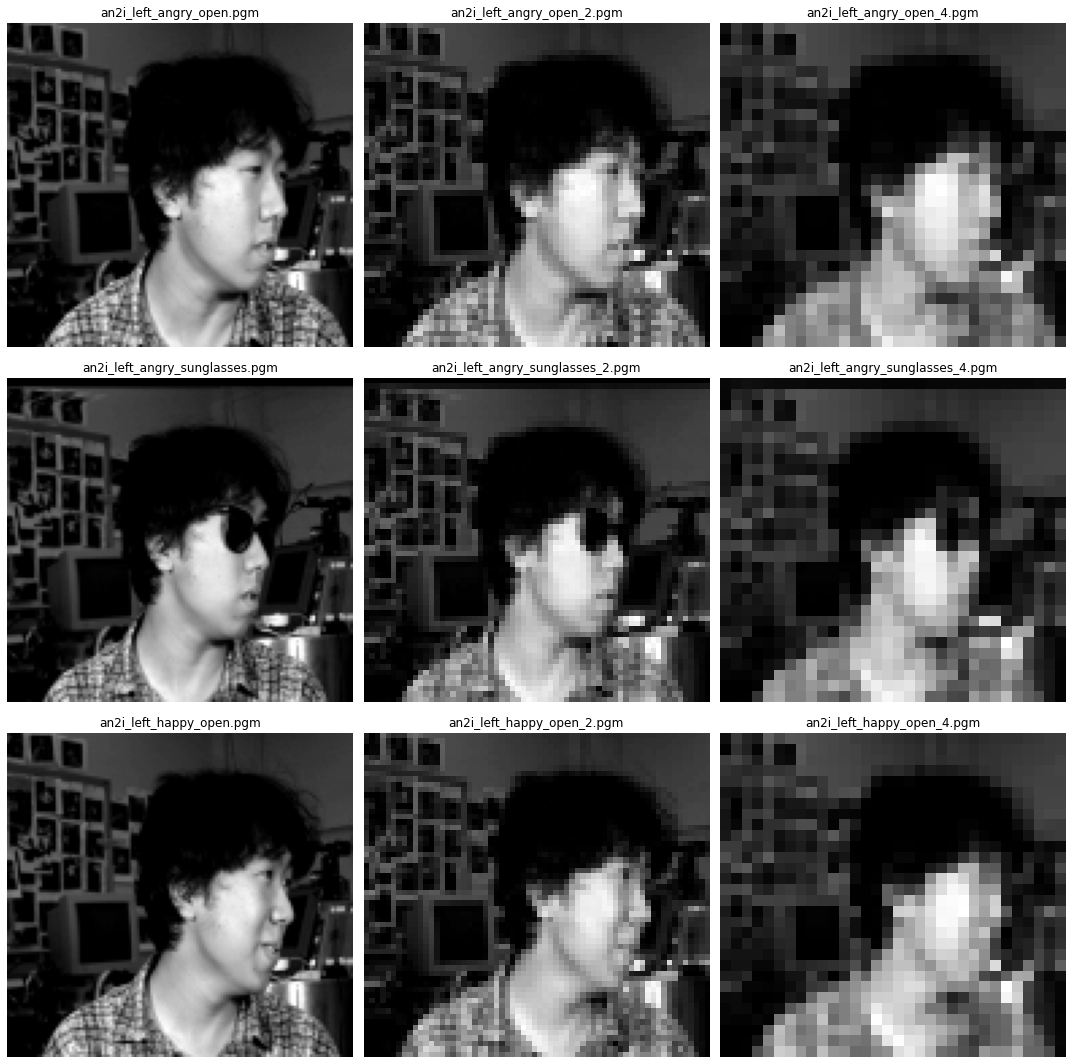

In [3]:
path = 'data/faces/'
folder = os.listdir(path)
if '.anonr' in folder:
    folder.remove('.anonr')
    
fd = 'an2i/'
photos = os.listdir(path+fd)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for ax, photo in zip(axes.flatten(), photos[:9]):
    img = cv2.imread(path+fd+photo, -1)

    ax.imshow(img, cmap='gray')
    ax.axis('off')  
    ax.set_title(photo)  
plt.tight_layout()
plt.show()

### Data Preprocessing
Data is processed in two steps, firstly, read in the pgm files as image, and resize the image to 224* 224* 3 shape, secondly, we can use HOG method to extract features from the image data with Histogram of Oriented Gradients (Dalal and Triggs, 2005). \

Hog is a widely used feature extracting method, which contains the procedures of 1. Data normalization, 2. Gradient calculation, 3. Orientation binning, 4. Descriptor blocks, 5. Feature vector. through this extraction, I obtain a lower dimension of image information which suits for SVM models. \

After the pre-processing, the dataset is devided into trainset and testset with percentage of 80%-20%, when trying to tune the hyperparameter , the train set is further devided randomly into 3-fold validation.

In [ ]:
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size)

def extractFeature(folder, hogEx):
    photos = os.listdir(folder)
    features = []
    labels = []
    for filename in photos:
        image_path = folder+filename
        if hogEx == True:
            resized_image = resize_image(cv2.imread(image_path, -1))
            feature, _ = hog(resized_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        else:
            feature = cv2.resize(cv2.imread(image_path), (224, 224))
                
        features.append(feature)
        labels.append(filename.split('.')[0].split('_')[:4])

    features = np.array(features)
    labels = np.array(labels)
    
    return features, labels
def trainTestDataPre(path,folder,hogEx=True):
    features, labels = extractFeature(path+folder[0]+'/',hogEx)
    for fd in folder[1:]:
        feature, label = extractFeature(path+fd+'/',hogEx)
        features = np.concatenate((features,feature))
        labels = np.concatenate((labels,label))
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
category = ['name','posture','facial expression','condition']
X_train_img, X_test_img, y_train_img, y_test_img = trainTestDataPre(path,folder,hogEx=False)

### CNN
For each dimension of str labels, I firstly transform them with one-hot encoding and use the N-dimensional vector as output, to fit the output forum of softmax in CNN.

The size of each convolution layer and fully connection hidden layer is decided with a grid-search, with respect to accuracy in 3-fold cross validation as a criteria, due to the computing capability limits, the hyperparameter is tuned using the third label which represents the expressions. 

The decided structure of CNN model contains three layers of convolution and each has 32 filters, and the model is fully connected with a neural network which has one hidden layer of 64 neurons.

In [ ]:
## Grid search to determine the hyperparameters, performance assessed with validset accuracy
i=2
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train[:,i])
onehot_encoded = to_categorical(integer_encoded, num_classes=len(np.unique(y_train[:,i])))

def modelHyperparameter(conv_1,conv_2,conv_3,hiddenLayer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(onehot_encoded.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def oneFoldTraining(X_train, y_train,X_valid,y_valid,model,returnMatrix=False):  
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    y_pred = model.predict(X_valid)
    y_pred = label_encoder.inverse_transform(np.argmax(y_pred,axis=1))
    average = 'macro'
    accuracy = accuracy_score(label_encoder.inverse_transform(np.argmax(y_valid,axis=1)), y_pred)
    if returnMatrix == True:
        recall = recall_score(y_test[:,i], y_pred, average=average)
        f1 = f1_score(y_test[:,i], y_pred, average=average)
        precise = precision_score(y_test[:,i], y_pred, average=average)
        re = pd.DataFrame([accuracy,precise,recall,f1],index=['accuracy','precise','recall','f1'],columns=[category[i]])
        return re
    return accuracy
def gridSearch(X_train_img,onehot_encoded):
    X_train, X_third, y_train, y_third = train_test_split(X_train_img, onehot_encoded, test_size=0.33, random_state=42)
    X_first, X_second, y_first, y_second = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
    parameter = {'conv_1':32,'conv_2':64,'conv_3':128,'hiddenLayer':128}
    accuracy_max = 0
    conv_ls = [128,64,32]
    hidden_ls = [128,64]
    for i in conv_ls:
        for j in conv_ls:
            for s in conv_ls:
                for t in hidden_ls:
                    model = modelHyperparameter(i,j,s,t)
                    acc1 = oneFoldTraining(X_train, y_train,X_third,y_third,model)  
                    acc2 = oneFoldTraining(np.concatenate((X_first,X_third)), np.concatenate((y_first,y_third)),X_second,y_second,model)
                    acc3 = oneFoldTraining(np.concatenate((X_second,X_third)), np.concatenate((y_second,y_third)),X_first,y_first,model)
                    accuracy = np.mean((acc1,acc2,acc3))
                    if accuracy > accuracy_max:
                        for key, new_value in zip(parameter.keys(), [i,j,s,t]):
                            parameter[key] = new_value
    return parameter
parameter = gridSearch(X_train_img,onehot_encoded)
file_path = 'parameterCNN.txt'
# Writing the dictionary to a text file
with open(file_path, 'w') as file:
    for key, value in parameter.items():
        file.write(f'{key}: {value}\n')

In [ ]:
## the tuned parameter are as follow:
parameter = {'conv_1': 32, 'conv_2': 32, 'conv_3': 32, 'hiddenLayer': 64}

In [5]:
result = pd.DataFrame()
for i in range(4):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_train[:,i])
    onehot_encoded = to_categorical(integer_encoded, num_classes=len(np.unique(y_train[:,i])))

    model = modelHyperparameter(parameter['conv_1'],parameter['conv_2'],parameter['conv_3'],parameter['hiddenLayer'])
    re = oneFoldTraining(X_train_img, onehot_encoded,X_test_img,y_test[:,i],model,returnMatrix=True)
    result = pd.concat([result,re],axis=1)
result.to_csv('result/ResultCNN.csv')

In [9]:
result

name   posture  facial expression  condition
accuracy  0.989418  0.828042           0.523810   0.989418
precise   0.987810  0.885352           0.521147   0.989071
recall    0.989621  0.829512           0.517641   0.989950
f1        0.988422  0.833585           0.518527   0.989399

# Convnet visualization
In this part, we read a pretrained model from keras and try to visualize what happened in each activation and filter of the model.

### A picture of cat from keras image files, and the model we are going to visualize is Xception

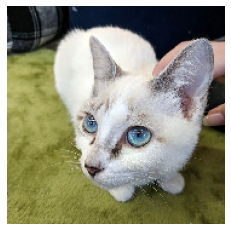

In [11]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [12]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 473ms/step


In [14]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, None, None, 728)      0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, None, None, 728)      536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, None, None, 728)      2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, None, None, 728)      536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, None, None, 728)      2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, None, None, 728)      0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, None, None, 728)      0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, None, None, 728)      0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, None, None, 728)      536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, None, None, 728)      0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, None, None, 728)      536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, None, None, 728)      2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, None, None, 728)      0         ['block12_sepconv3_bn[0][0]', 
          

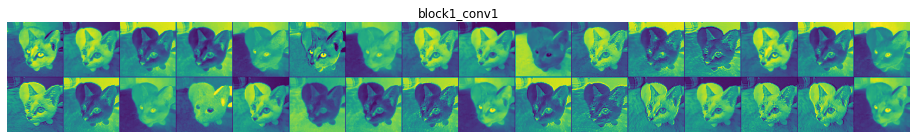

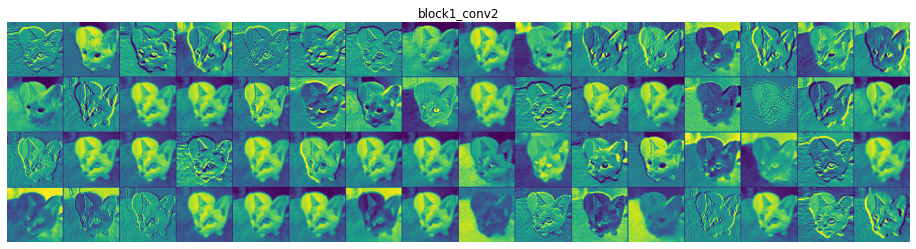

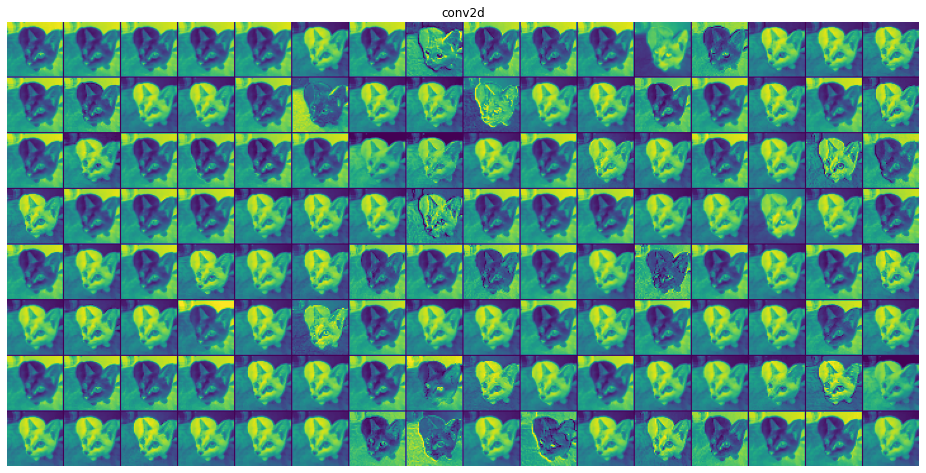

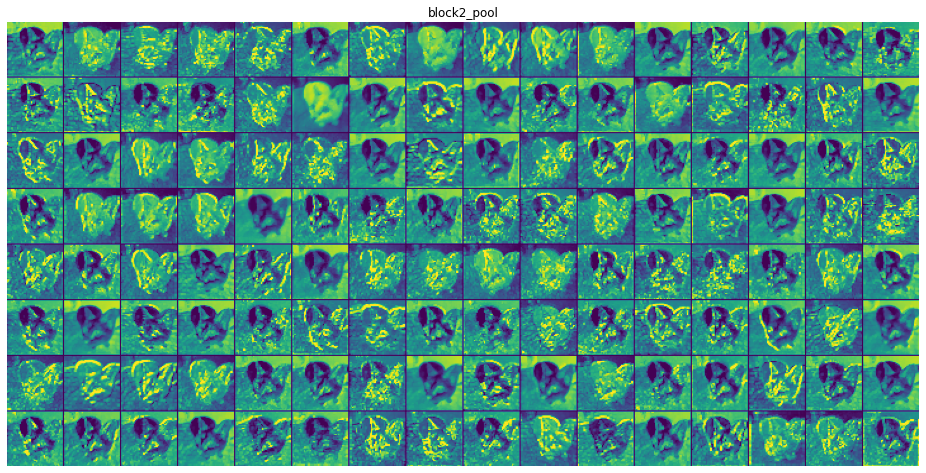

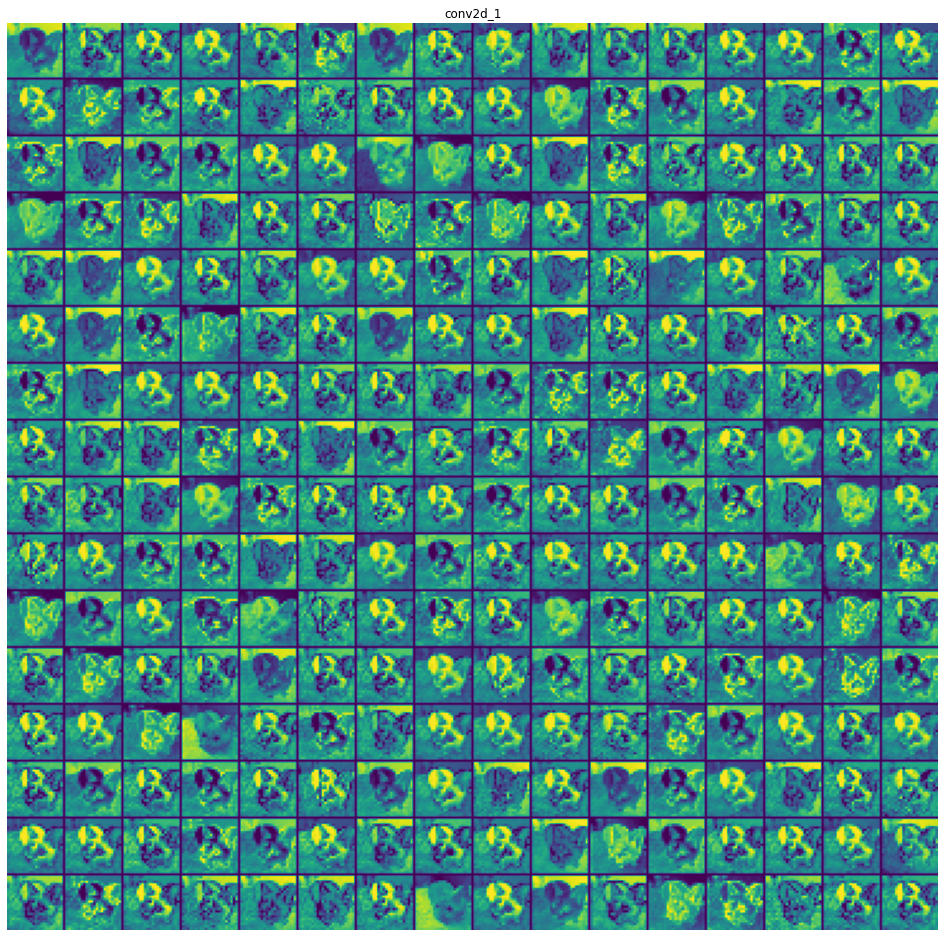

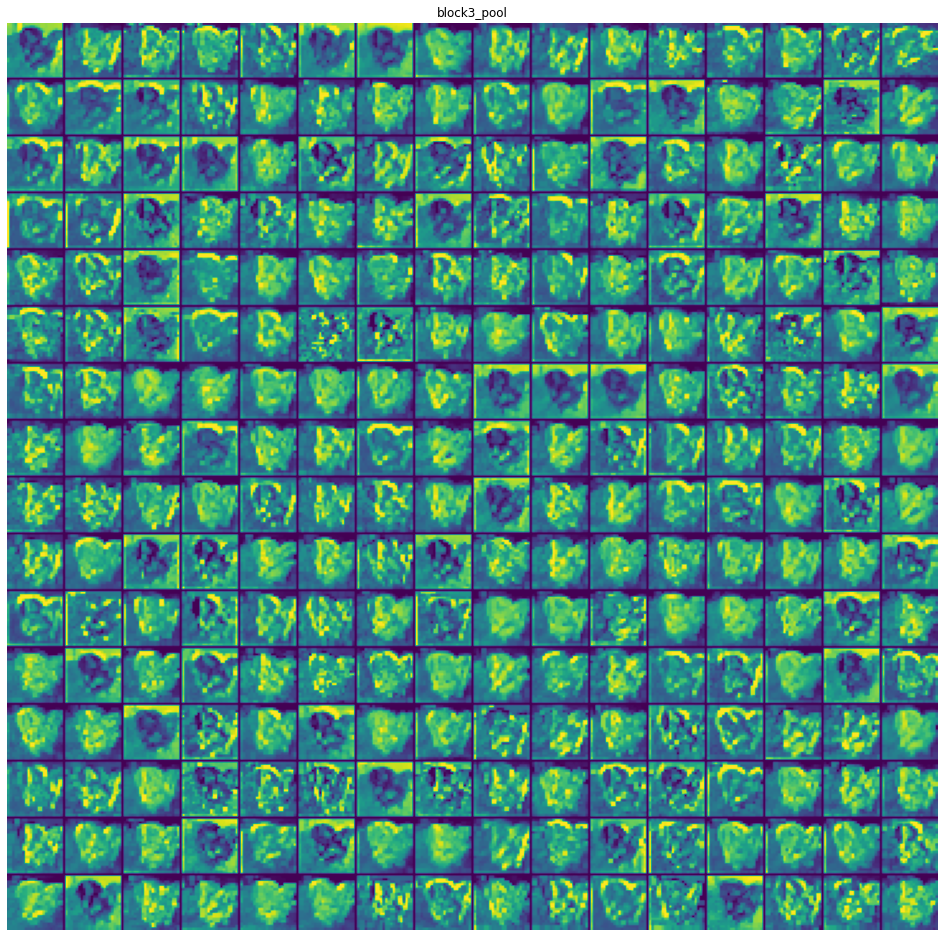

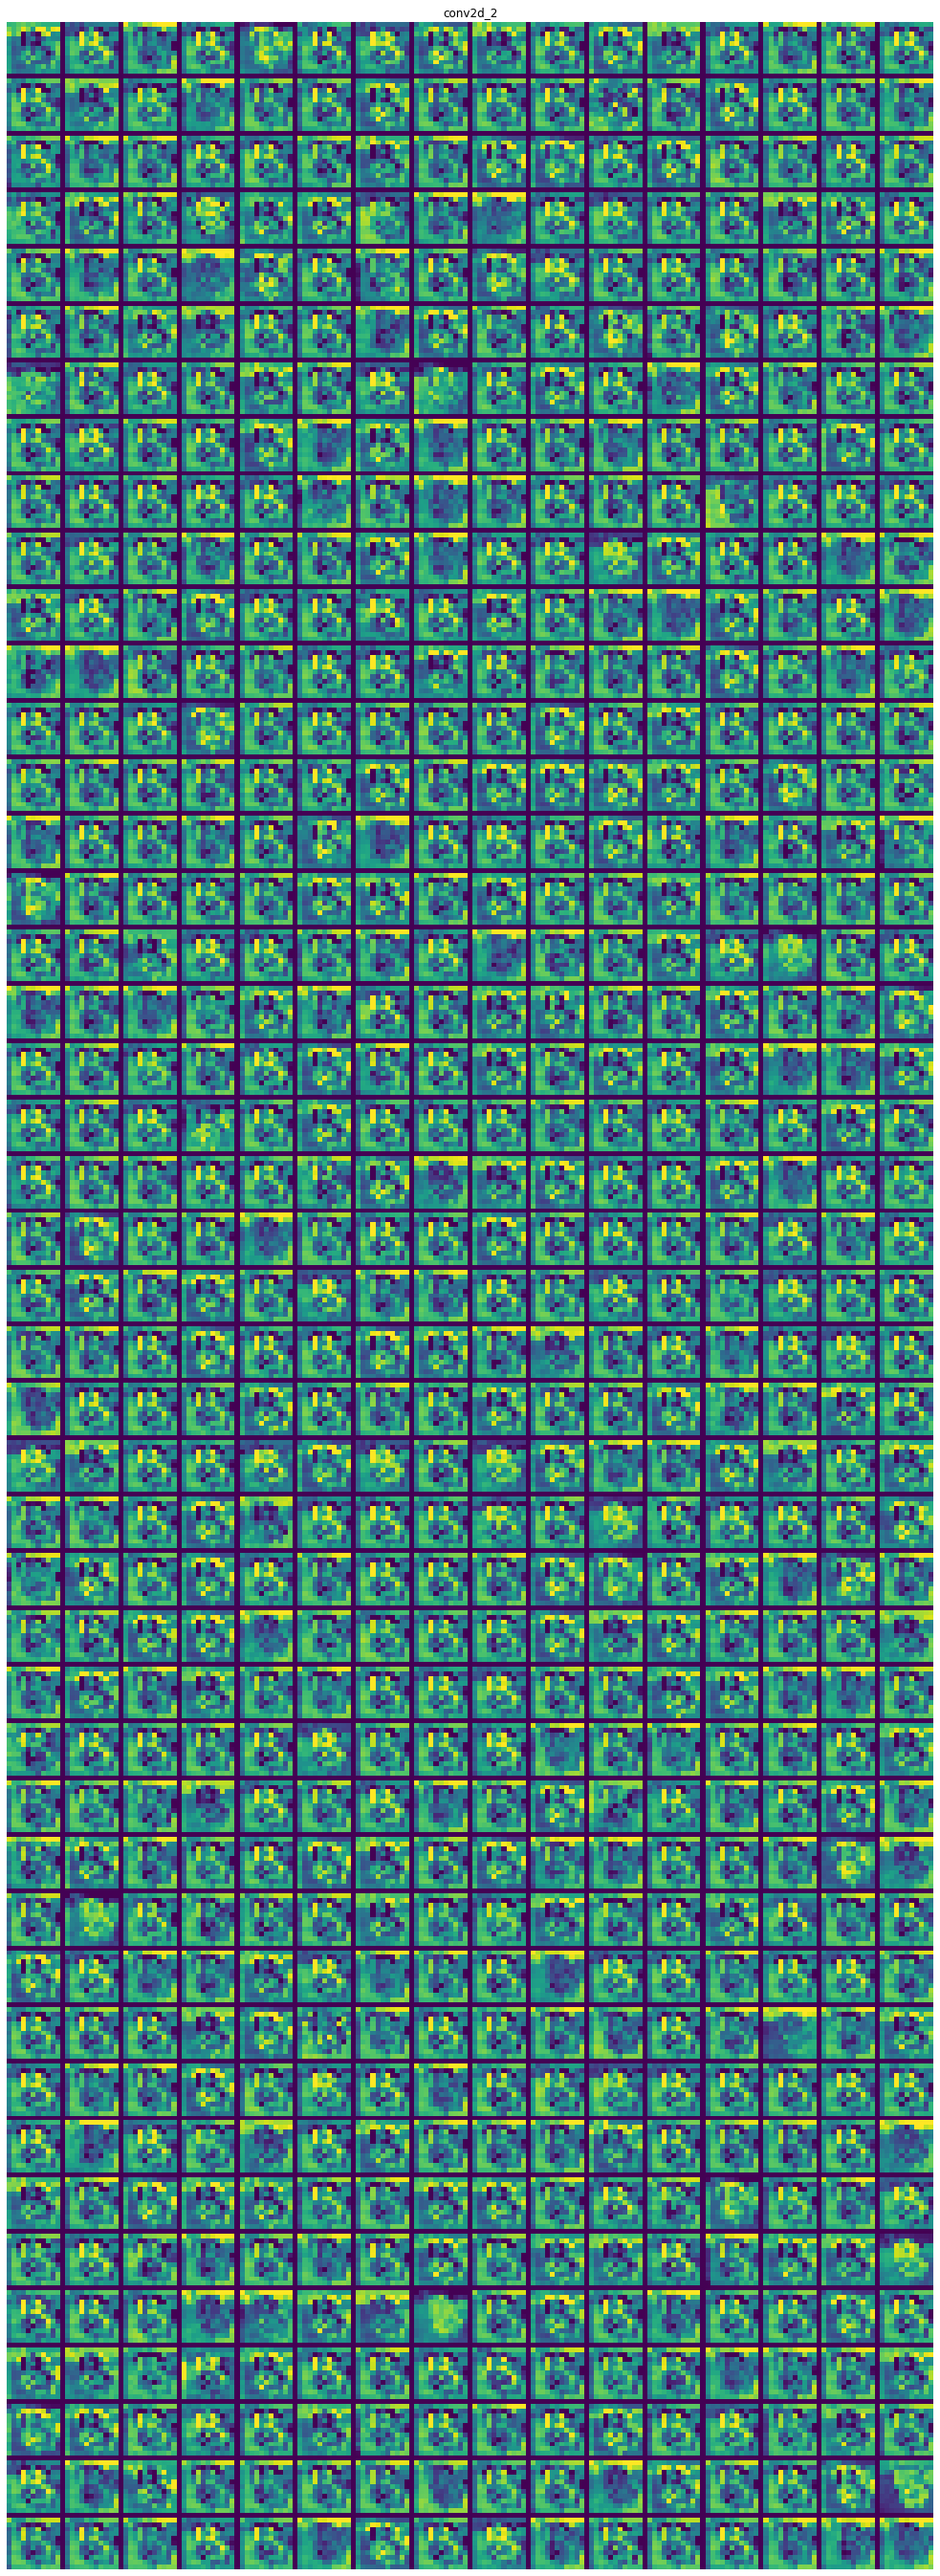

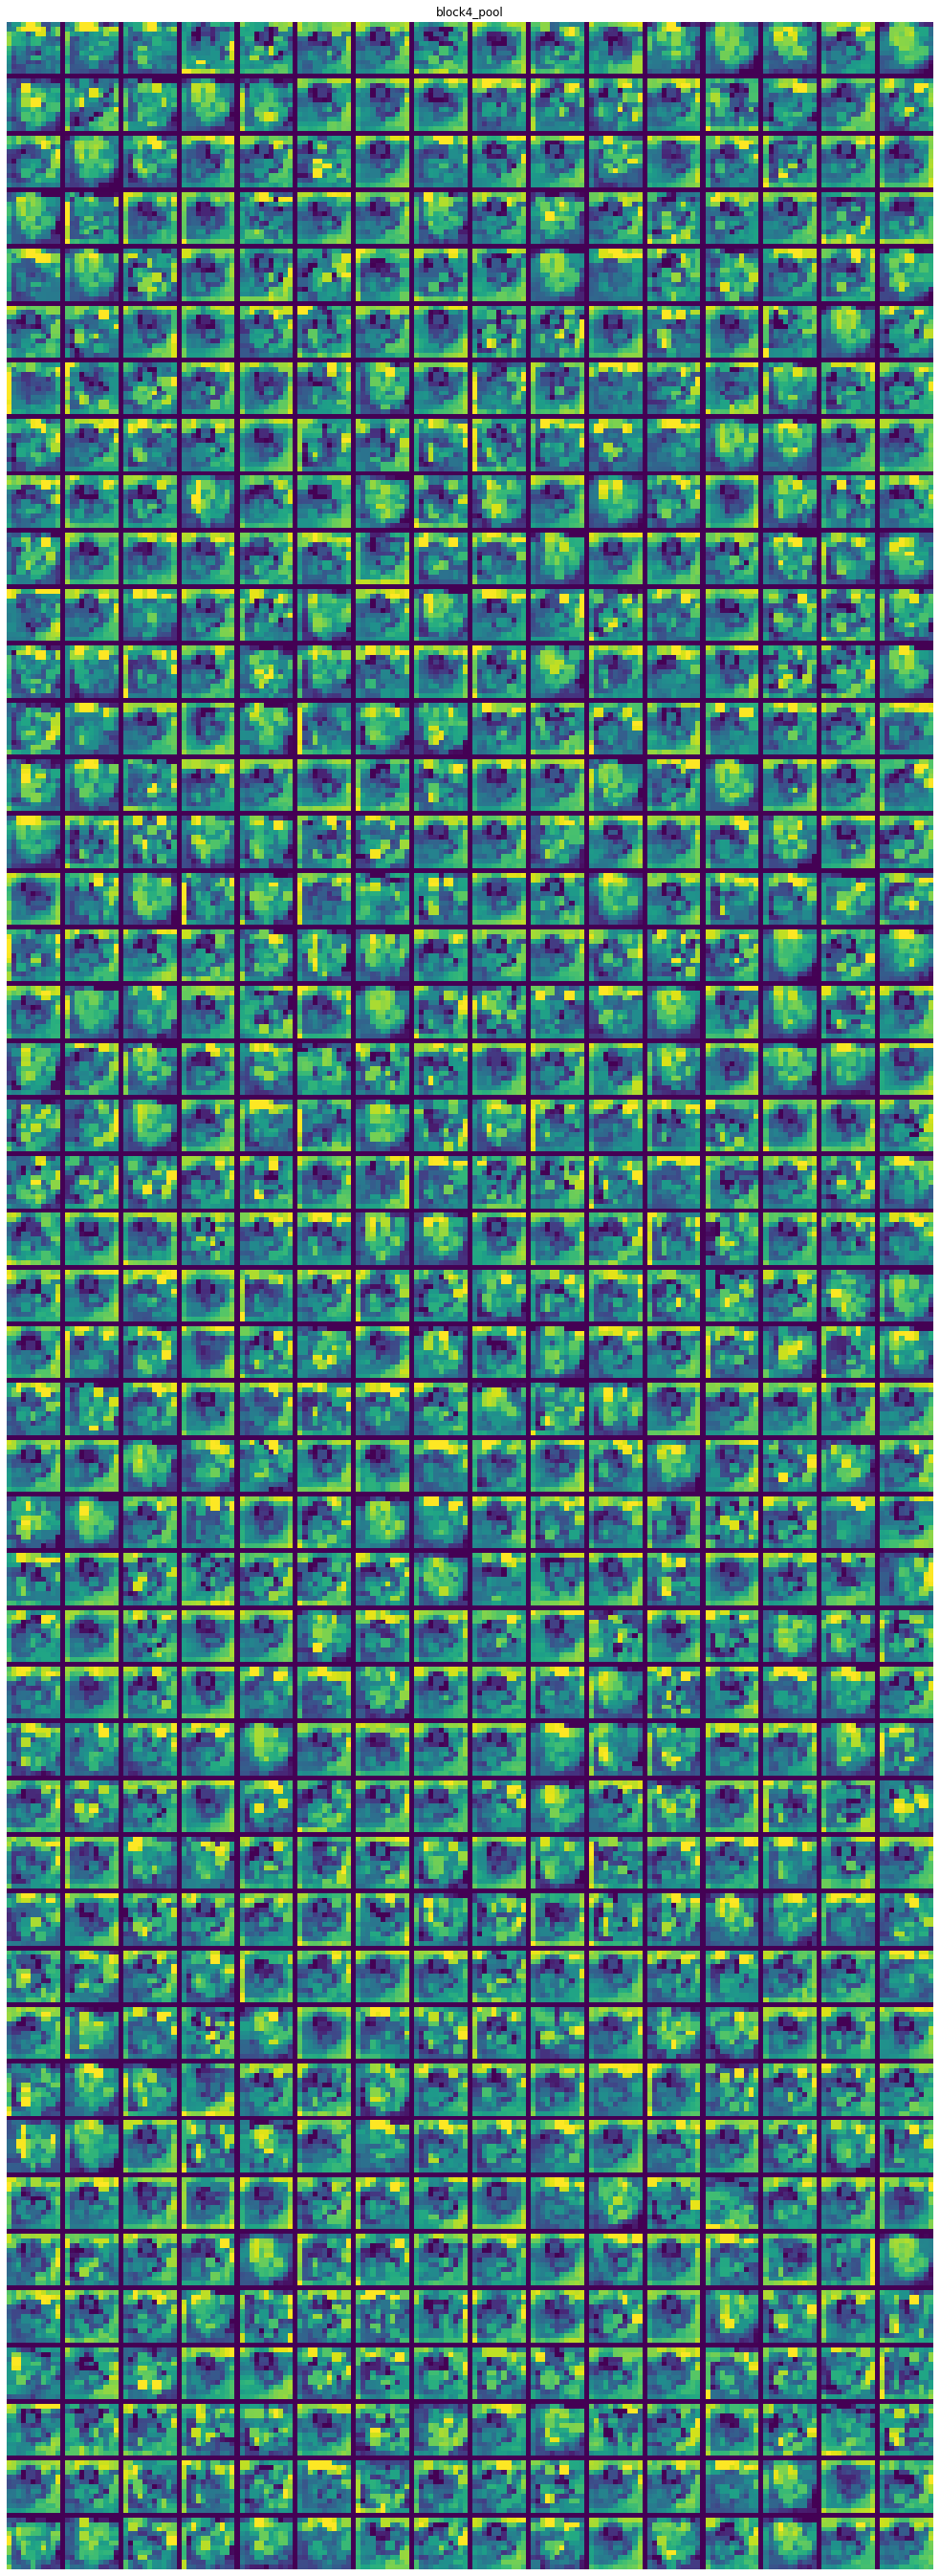

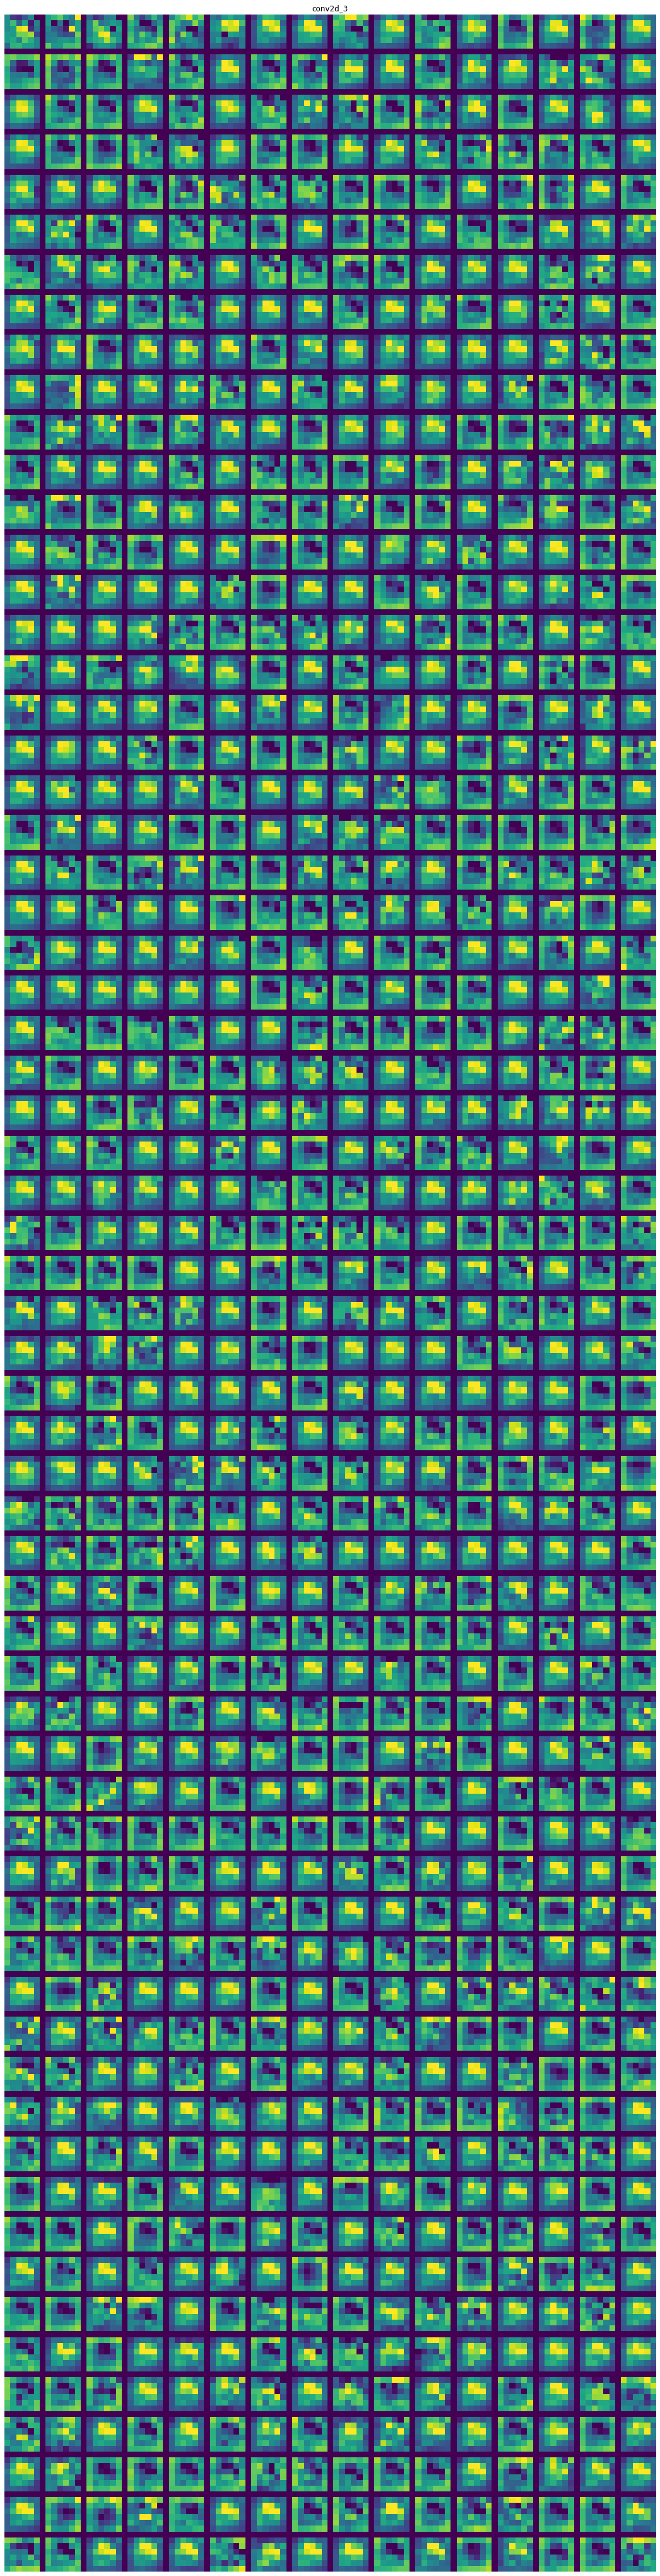

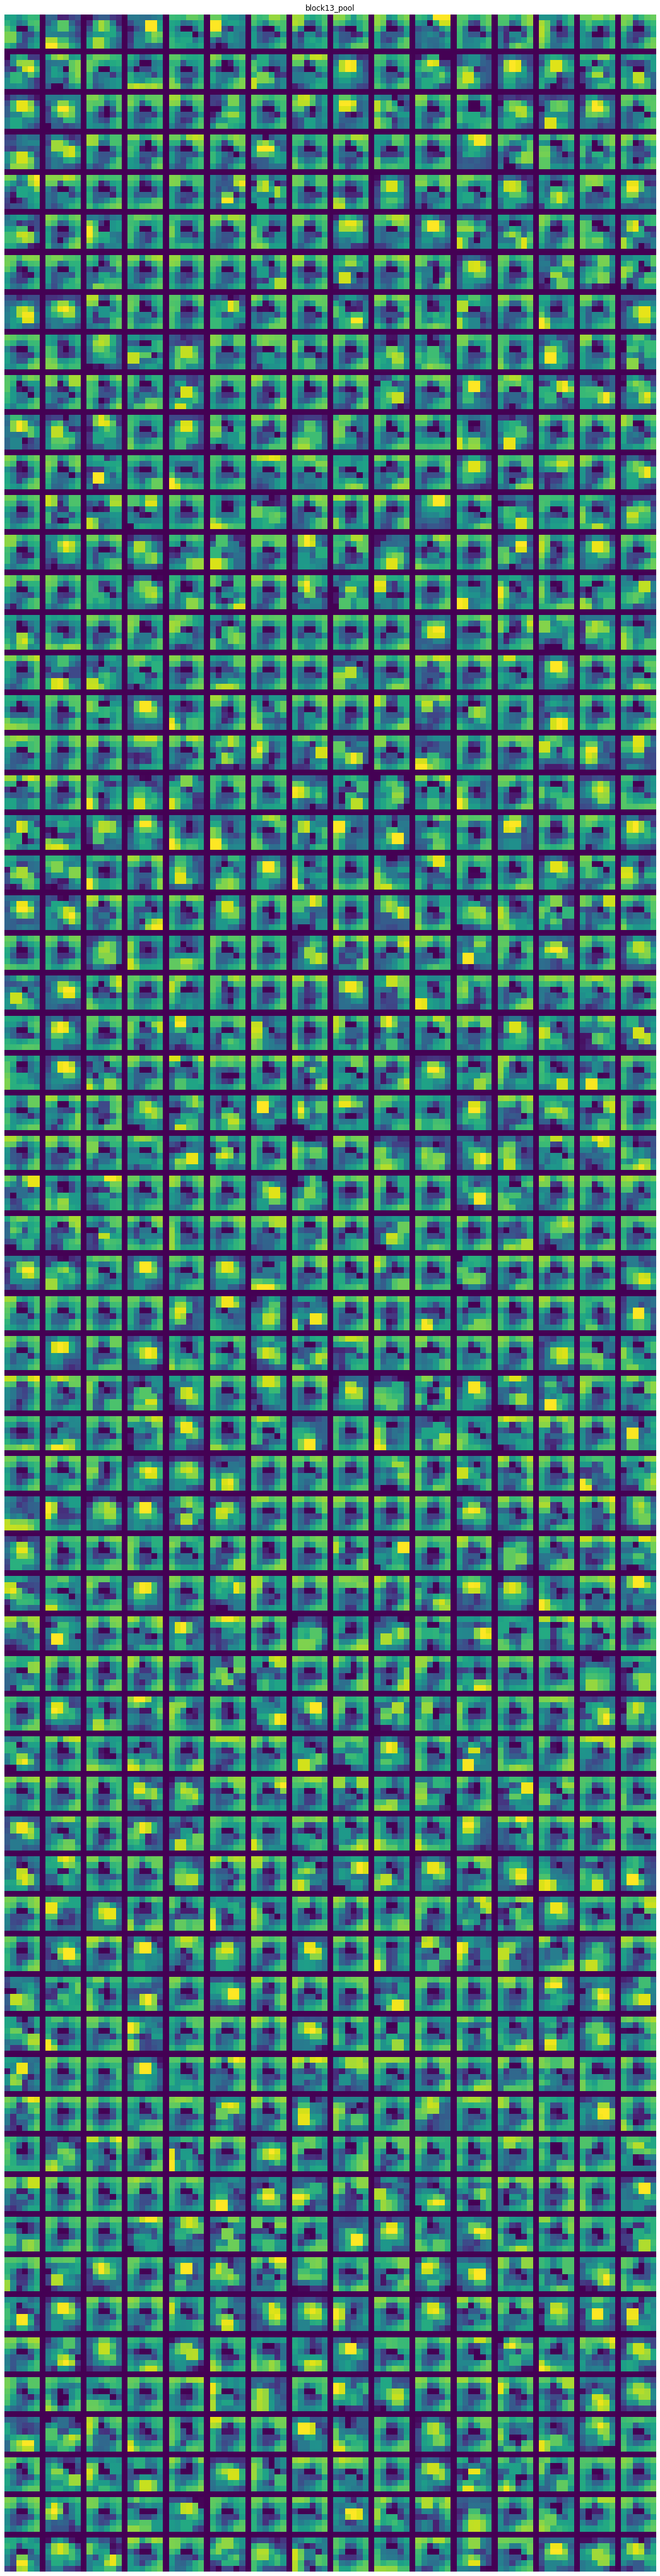

In [13]:
## for each channel in each intermediate activation, plot the channels
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

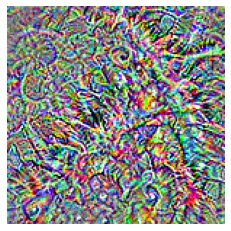

In [16]:
## Plot the filter in one layer
import tensorflow as tf
layer_name = "block9_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

##Loss maximization via stochastic gradient ascent
@tf.function
def SGA(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = tf.reduce_mean(feature_extractor(image)[:, 2:-2, 2:-2, filter_index])
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, 200, 200, 3))
    for i in range(iterations):
        image = SGA(image, filter_index, learning_rate)
    return image[0].numpy()

def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))